# Predict the distribution of product sales based on visits
_Predictive_

**Steps**


In [199]:
# ========== ----- ========== Import Libraries ========== ----- ========== #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.arima_model as arima
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# ========== ----- ========== End ========== ----- ========== #

In [200]:
# ========== ----- ========== Load Dataset ========== ----- ========== #

company_id = '5c990b2b4382f61588e2c0c7' # Dermazone
promoters_df = pd.read_json('dataset/promoters_sales.json', orient='records')
promoters_df = promoters_df.loc[(promoters_df['company_id'].str.get('$oid') == company_id)]
df = promoters_df[['sales']]
df.head()

# ========== ----- ========== End ========== ----- ========== #

,sales
0,"[{'_id': {'$oid': '5ccdf985af815d0015c804e7'},..."
1,"[{'_id': {'$oid': '5d192b23bc6d25001598e786'},..."
2,"[{'_id': {'$oid': '5cf1d4d64da32200154b8272'},..."
3,"[{'_id': {'$oid': '5cf1d4d64da32200154b8270'},..."
4,"[{'_id': {'$oid': '5dbb4bcb2df9430015ffbcfa'},..."


### Data Preproccessing

In [201]:
# ========== ----- ========== Get Sales ========== ----- ========== #

# unroll sales
sales = df.explode('sales', ignore_index=True)

# add product column
sales['product'] = sales['sales'].map(lambda x: x.get('product'))

# add cost
sales['price'] = sales['sales'].map(lambda x: x.get('total_amount'))

# add creation date
sales['date'] = sales['sales'].map(lambda x: x.get('created_at'))

# drop the sales column
sales.drop(['sales'], axis=1, inplace=True)

# filter the rows contains null values
sales = sales.dropna(how='any')

# map the product into names
sales['product'] = sales['product'].map(lambda x: x.get('name'))

# convert the data value into date object
sales['date'] = pd.to_datetime(sales['date'].map(lambda x: x['$date']))

sales.head()

# ========== ----- ========== End ========== ----- ========== #

,product,price,date
0,DERMAGLOW,1190.0,2019-05-04 23:43:28.476000+00:00
1,BEAUTY GUMMIES,716.0,2019-05-04 23:43:28.476000+00:00
2,ZORI GUMMIES,196.0,2019-05-04 23:43:28.476000+00:00
3,OMEGA 3 CHOCO FISHES,358.0,2019-05-04 23:43:28.476000+00:00
4,DERMAGLOW,1190.0,2019-05-04 23:43:28.476000+00:00


In [202]:
# ========== ----- ========== Get Sales ========== ----- ========== #

# extract the names and sales
product_total_sales = sales.groupby('product').count()
product_total_sales = product_total_sales.drop('date', axis=1)
# product_total_sales['count'] = product_total_sales['price']
product_total_sales.rename(columns={'price': 'count'}, inplace=True)

# sorting
product_total_sales.sort_values(['count'], inplace=True, ascending=False)
product_total_sales.head()

# ========== ----- ========== End ========== ----- ========== #

,count
product,
GROW ME SHAMPOO 200 ML,1395
BEAUTY GUMMIES 60 PCs,1265
BEAUTY GUMMIES,1224
GROW ME CONDITIONER 200 ML,1014
ADVANCED CLEANSER 150 ML,967


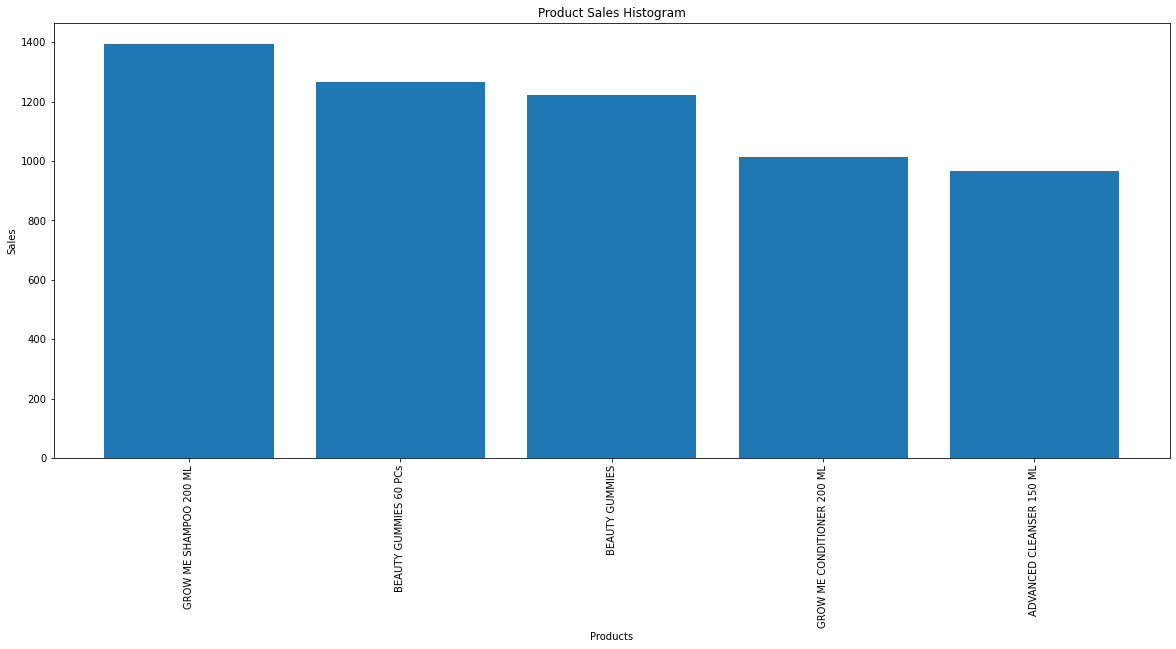

In [203]:
# ========== ----- ========== Highly 5 Products ========== ----- ========== #

# get the highly 5 products
top_products = product_total_sales.iloc[: 5]
# draw the highly sales products
plt.figure(figsize=(20, 8))

plt.bar(top_products.index, top_products['count'])

plt.xlabel('Products')
plt.ylabel('Sales')
plt.title('Product Sales Histogram')
plt.xticks(rotation='vertical')
plt.show()

# ========== ----- ========== End ========== ----- ========== #

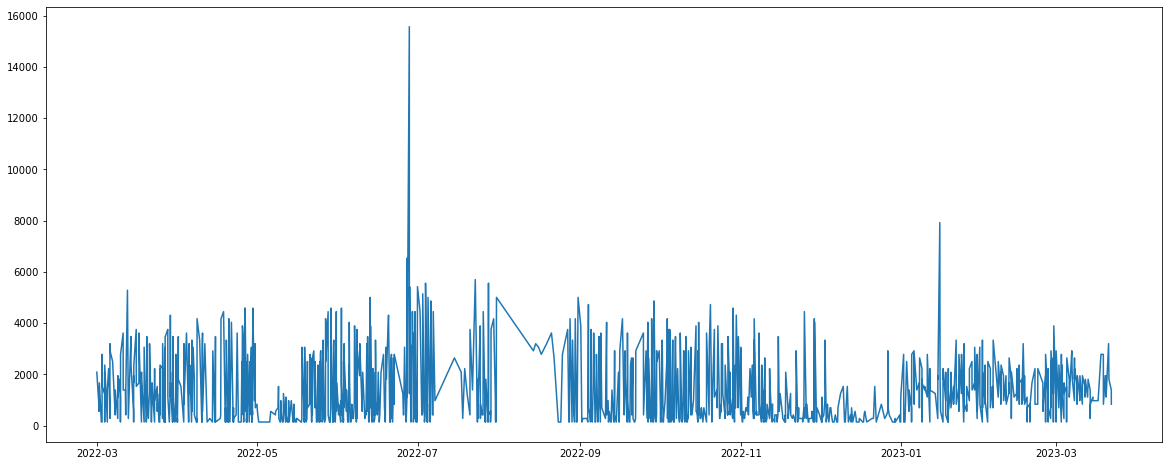

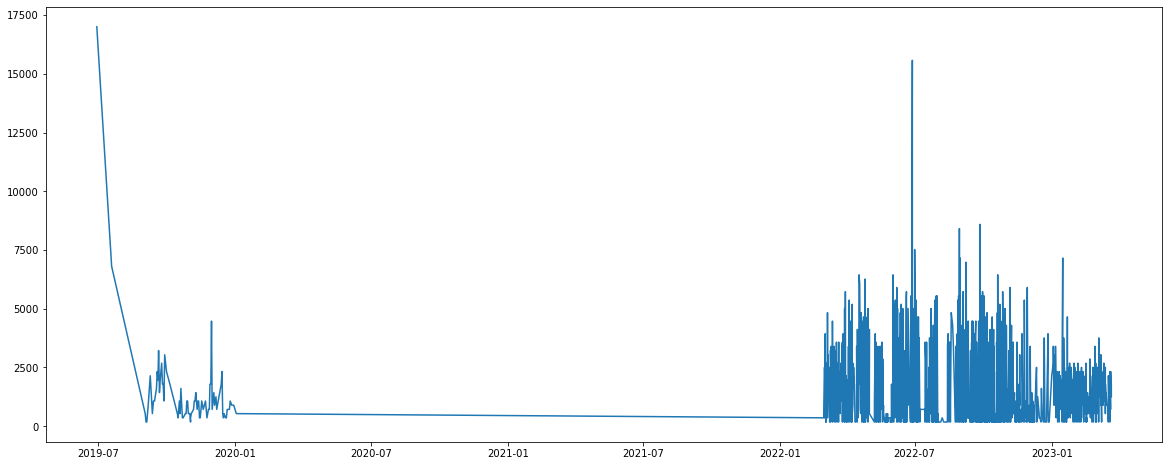

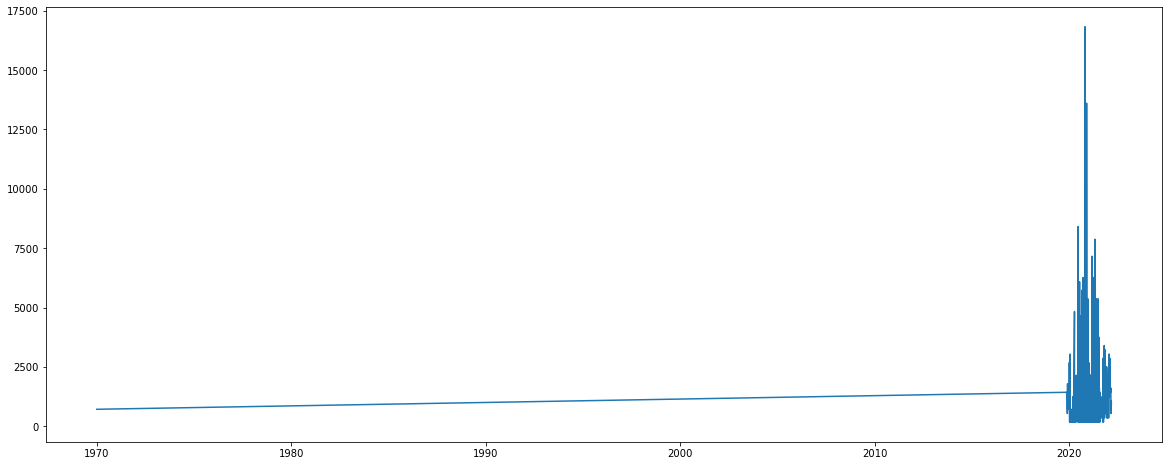

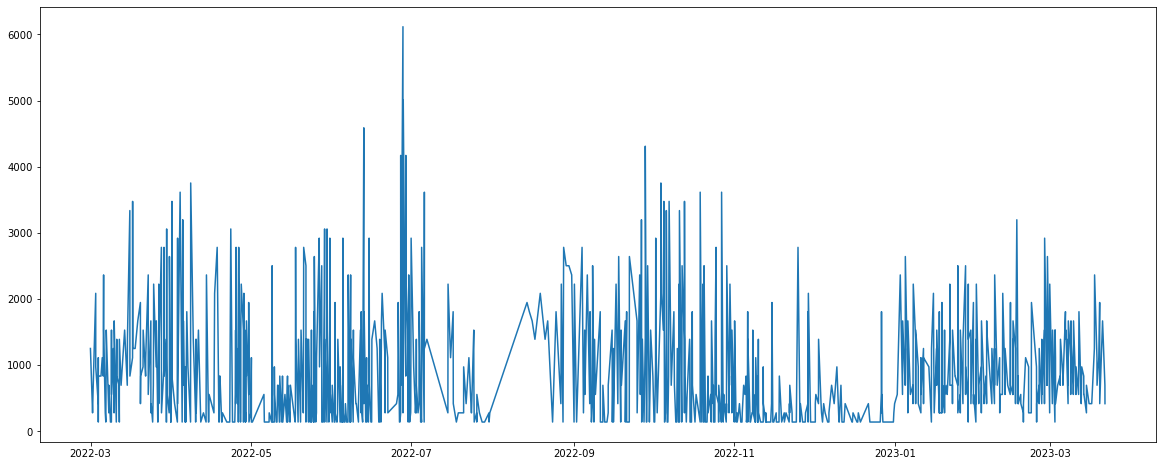

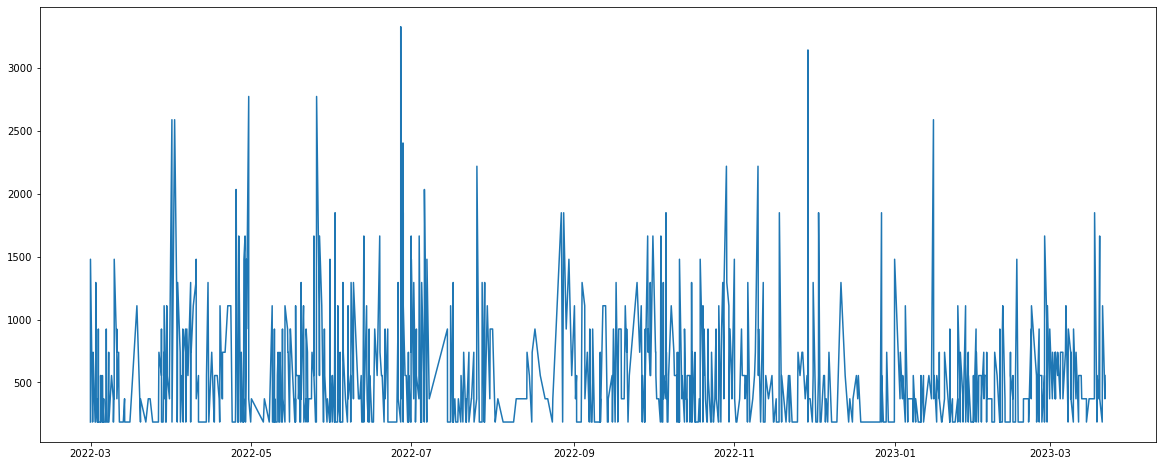

In [204]:
# ========== ----- ========== Highly 5 Products ========== ----- ========== #

# group by product name
product_groups = sales.groupby(['product'])

groups = {}

for name, group_df in product_groups:
    # drop the product name
    group_df.drop(['product'], axis=1, inplace=True)
    # rearange the columns
    group_df = group_df[['date', 'price']]
    # assign the df to the group name
    groups[name] = group_df

for product_name in top_products.index:
    df = groups.get(product_name)
    df.sort_values(['date'], inplace=True)
    plt.figure(figsize=(20, 8))
    plt.plot(df['date'], df['price'])

plt.show()

# ========== ----- ========== End ========== ----- ========== #

MSE: 312.5276451973714


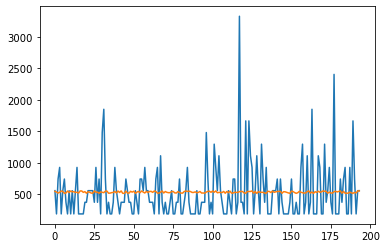

In [205]:
# ========== ----- ========== Linear Regression ========== ----- ========== #
from datetime import datetime

fifth_df = groups[top_products.index[4]]
fifth_df.sort_values(['date'], inplace=True)


# Convert the 'date' column to datetime objects
fifth_df['date'] = pd.to_datetime(fifth_df['date'])

# Convert the datetime objects to numeric timestamps
fifth_df['date'] = pd.to_numeric(
    fifth_df['date'].apply(lambda x: x.timestamp()))

# Create date index from the month column
# fifth_df.set_index('date', inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    fifth_df.drop('price', axis=1), fifth_df['price'], test_size=0.2, random_state=42)

# Fit linear regression model to training data
model = LinearRegression()
model.fit(X_train, y_train)

# Generate forecasts for test data
y_pred = model.predict(X_test)

# Evaluate model performance using mean squared error
mse = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')


# Plot the data as a line
plt.plot(y_test.reset_index()['price'])
plt.plot(y_pred)

# Show the plot
plt.show()

# ========== ----- ========== End ========== ----- ========== #


In [206]:
y_test = y_test.reset_index()
y_test


,index,price
0,18013,555.0
1,22205,185.0
2,29186,740.0
3,24045,925.0
4,14671,185.0
...,...,...
189,31798,1665.0
190,24400,740.0
191,27663,185.0
192,14250,555.0
